Heavily leveraging example given here https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_online_wine.html

In [ ]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

In [ ]:
wine_data = load_wine()
feature_names = wine_data.feature_names

X, y = wine_data.data, wine_data.target
X_ref, X_test, y_ref, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import numpy as np
import scipy

In [ ]:
%pip install alibi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 24.2.0
    Uninstalling attrs-24.2.0:
      Successfully uninstalled attrs-24.2.0
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.24.0
    Uninstalling scikit-image-0.24.0:
      Successfully uninstalled scikit-image-0.24.0


In [ ]:
%pip install alibi-detect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.5/381.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0


In [ ]:
import alibi
from alibi_detect.cd import TabularDrift

cd = TabularDrift(x_ref=y_ref, p_val=.05)

preds = cd.predict(y_test)
labels= ['No', 'Yes']
print('Drift: {}'.format(labels[preds['data']['is_drift']]))

Drift: No


/usr/local/lib/python3.10/dist-packages/alibi_detect/cd/tabular.py:113: UserWarning: No `categories_per_feature` dict provided so all features are assumed to be numerical. `KSDrift` will be applied to all features.
  warnings.warn('No `categories_per_feature` dict provided so all features are assumed to be numerical. '


In [ ]:
y_test_cal_error = 1.1*y_test
preds = cd.predict(y_test_cal_error)
labels = ['No', 'Yes']
print('Drift: {}'.format(labels[preds['data']['is_drift']]))


Drift: Yes


In [ ]:
from alibi_detect.cd import MMDDriftOnline

In [ ]:
ert = 50
window_size = 10
cd = MMDDriftOnline(X_ref, ert, window_size, backend='pytorch', n_bootstraps=2500)

Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


In [ ]:
def time_run(cd, X, window_size):
    n = X.shape[0]
    perm = np.random.permutation(n)
    t = 0
    cd.reset_state() #updated based on git issue!
    while t<250:
        #print(t%n)
        pred = cd.predict(X[perm[t%n]])
        if pred['data']['is_drift'] == 1:
            return t
        else:
            t += 1

In [ ]:
n_runs = 4
#times_h0 = [time_run(cd, X_h0, window_size) for _ in range(n_runs)]
times_h0 = [time_run(cd, X_ref, window_size) for _ in range(n_runs)] #changed to X_ref just to run a test, change back!
print(times_h0)

[None, 88, 47, 22]


In [ ]:
cd.reset_state()

In [ ]:
n = X.shape[0]
perm = np.random.permutation(n)
t = 0

In [ ]:
cd.predict(X[perm[6%n]])

{'data': {'is_drift': 0,
  'distance': None,
  'p_val': None,
  'threshold': 0.09236781684106739,
  'time': 26388,
  'ert': 50,
  'test_stat': -0.06372885421774888},
 'meta': {'name': 'MMDDriftOnlineTorch',
  'online': True,
  'data_type': None,
  'version': '0.12.0',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

In [ ]:
import pandas as pd

In [ ]:
df_X_ref = pd.DataFrame(X_ref)

In [ ]:
df_X_test = pd.DataFrame(X_test)

<Axes: >

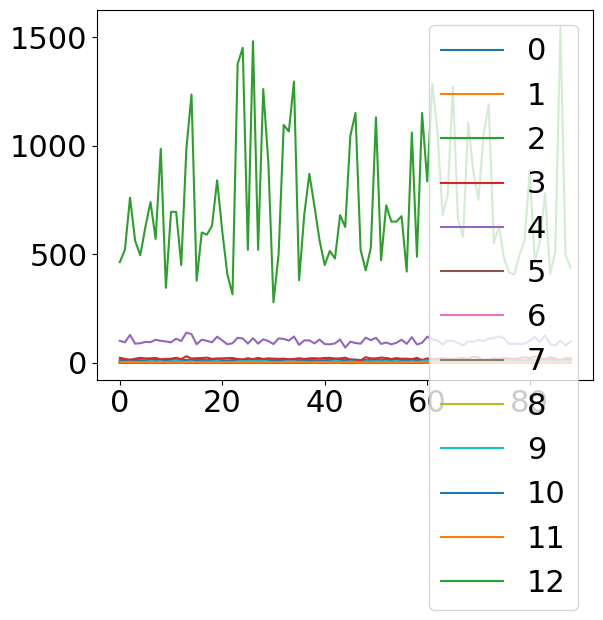

In [ ]:
df_X_ref.plot()

<Axes: >

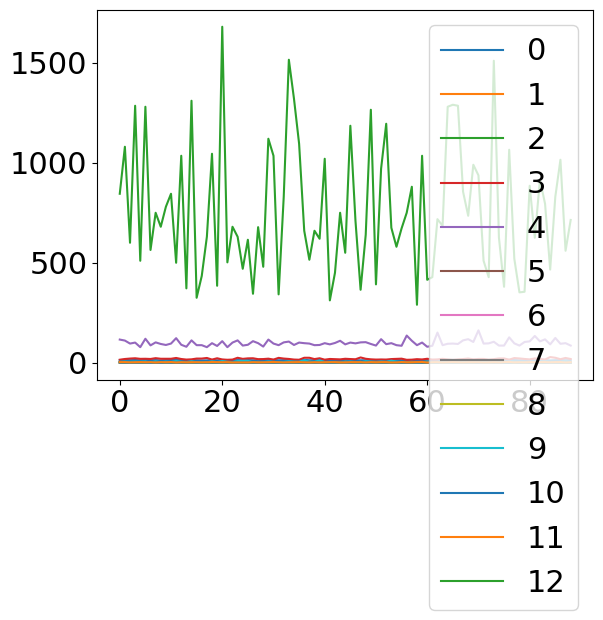

In [ ]:
df_X_test.plot()

<Axes: >

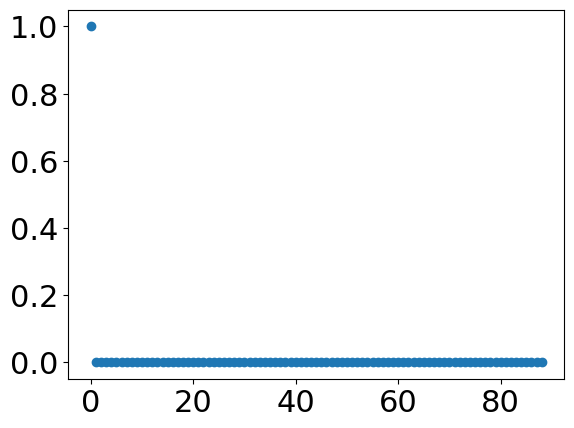

In [ ]:
df_X_test.apply(lambda x: cd.predict(x.values)['data']['is_drift'], axis=1).plot(marker='o', linewidth=0)

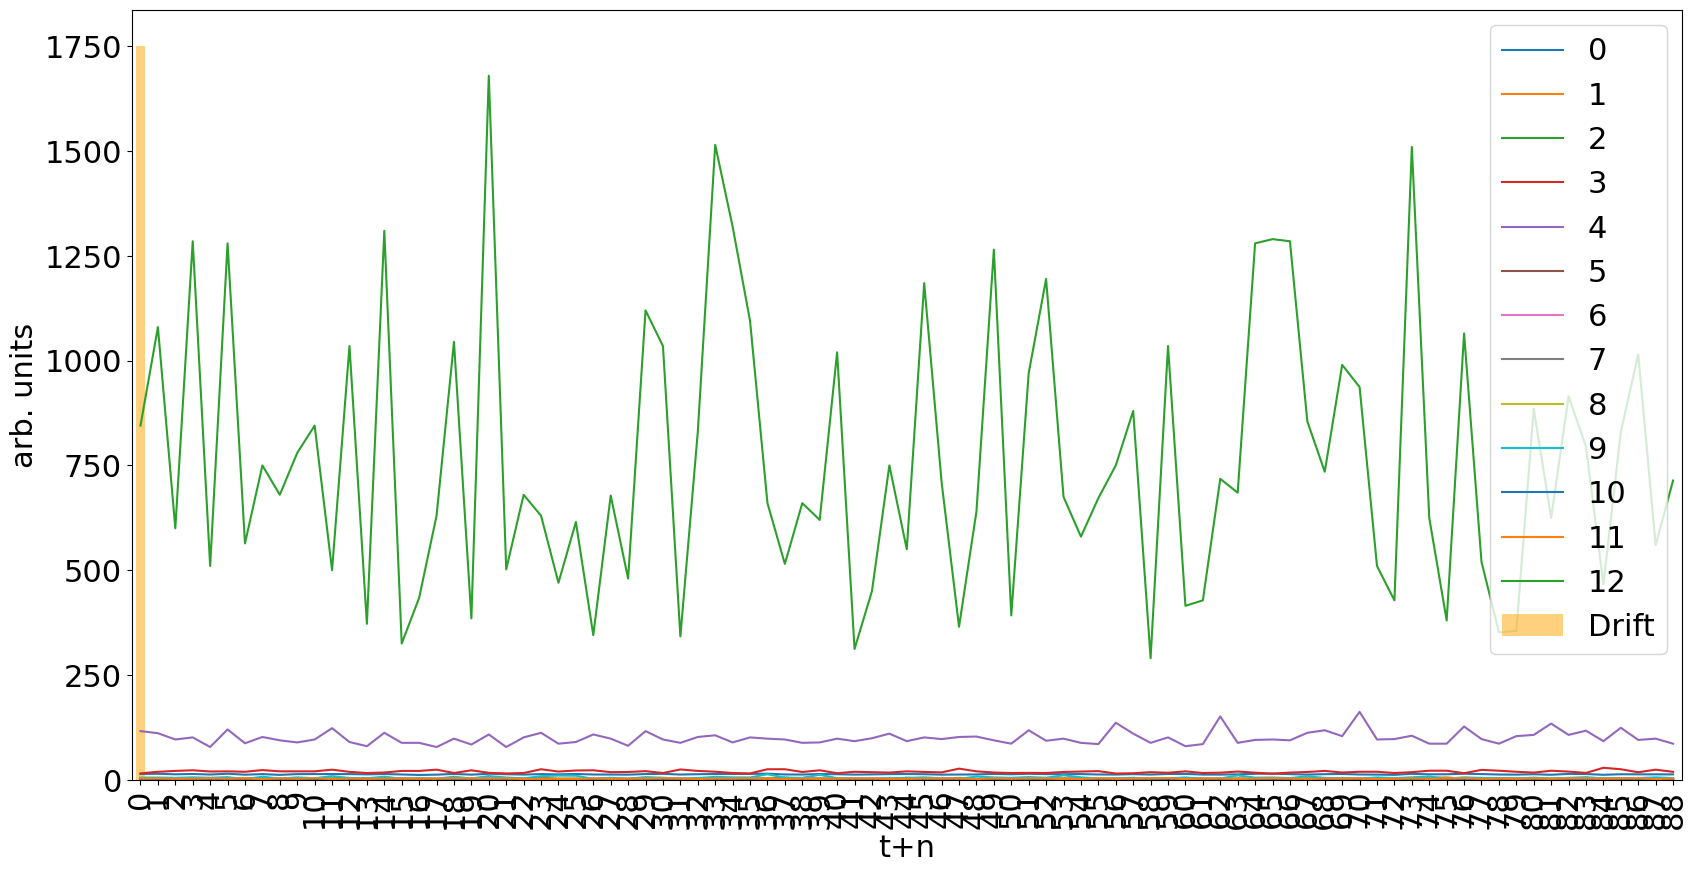

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
df_X_test.plot(ax=ax, label='_nolegend_')
df_X_test.apply(lambda x: 1750*cd.predict(x.values)['data']['is_drift'], axis=1).plot(kind='bar', ax=ax, color='orange', alpha=0.5, label='Drift')
ax.set_xlabel('t+n')
ax.set_ylabel('arb. units')
ax.legend(loc='upper right', shadow=True)
plt.legend()

['_0', '_1', '_2', '_3', '_4', '_5', '_6', '_7', '_8', '_9', '_10', '_11', 'Features']


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:813: UserWarning: The label '_0' of <matplotlib.lines.Line2D object at 0x784eb8d65e70> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:813: UserWarning: The label '_1' of <matplotlib.lines.Line2D object at 0x784eb8d66230> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:813: UserWarning: The label '_2' of <matplotlib.lines.Line2D object at 0x784eb8d665c0> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:813: UserWarning: The label '_3' of <matplotlib.lines.Line2D object at 0x784eb8d66950> starts with '_'. It is t

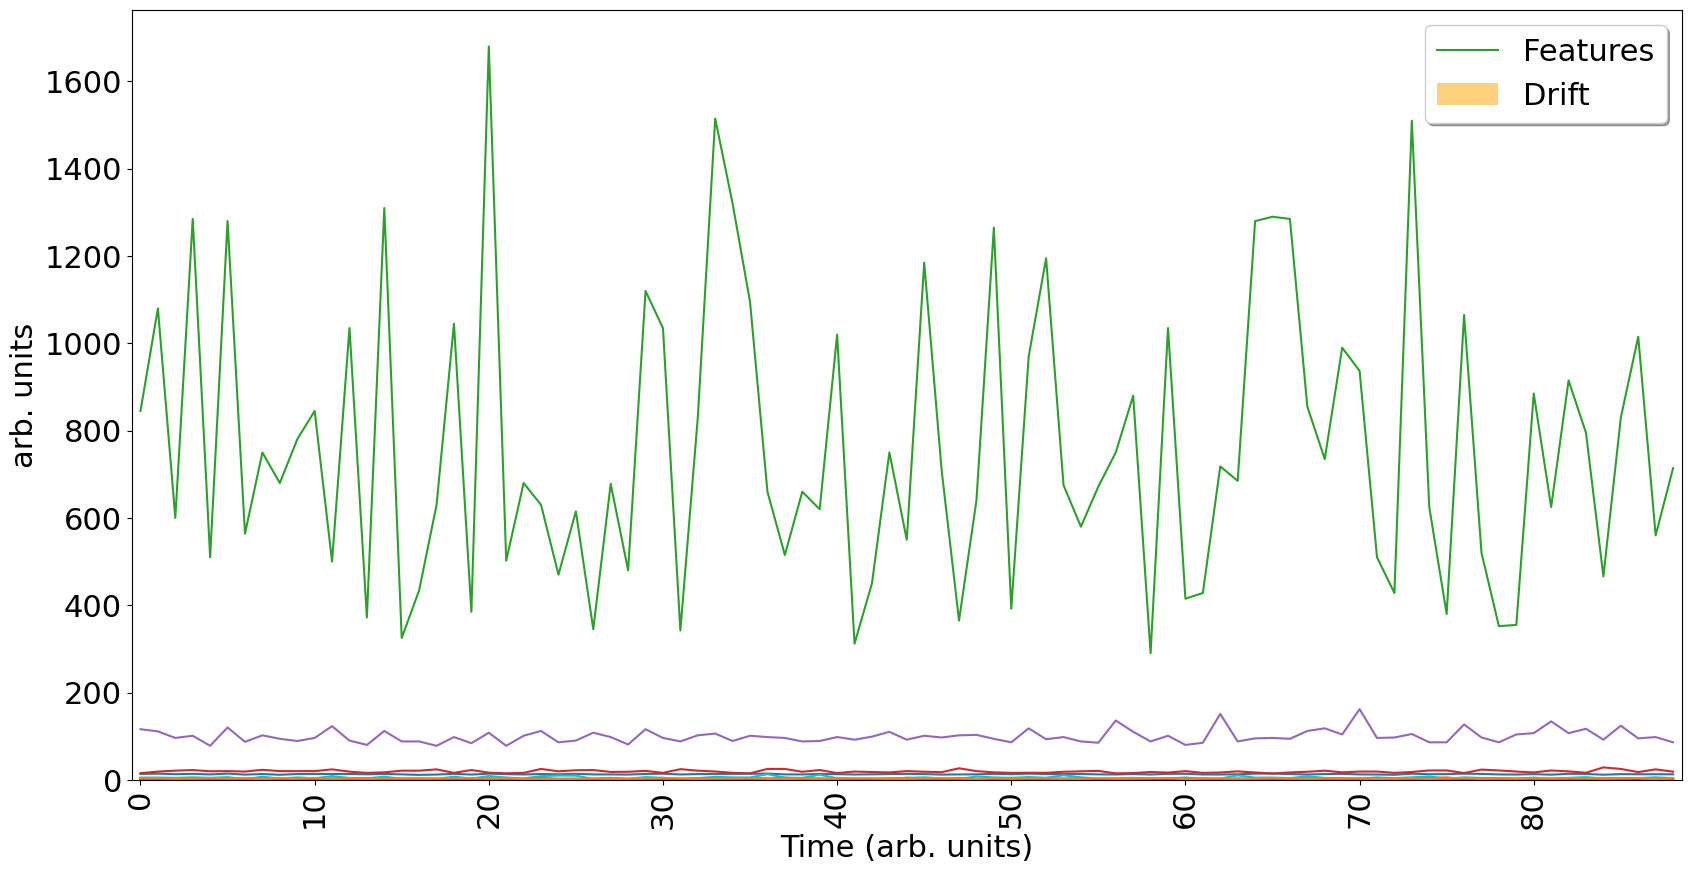

In [ ]:
#### SIMULATE DRIFT DETECTION AND PLOT - USE A LAMBDA
fig, ax = plt.subplots(figsize=(20,10))

cols = ["_" + str(col) for col in df_X_test.columns]
cols[-1] = 'Features'
print(cols)
df_X_test.columns = cols

df_X_test.plot(ax=ax)
ax.set_xlabel('Time (arb. units)')
ax.set_ylabel('arb. units')

ax2= df_X_test.apply(lambda x: 1750*cd.predict(x.values)['data']['is_drift'], axis=1).plot(
    kind='bar',
    ax=ax,
    color='orange',
    alpha=0.5,
    label='Drift')

ax2.legend(loc='upper right', shadow=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(9))

In [ ]:
#assume X=np.array
def simulate_drift_detection(cd, X):
    drift_detected = []
    print(len(X))
    if len(X)>100:
        return 0
    else:
        for row in X:
            cd.reset_state()
            drift_detected.append(cd.predict(row)['data']['is_drift'])
        return drift_detected

**Feature importance**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_ref, y_ref)
mdi_importances = pd.Series(rf[-1].feature_importances_, index=feature_names).sort_values(ascending=True)
print(mdi_importances)
print(X)

alcohol                         0.000000
malic_acid                      0.000000
ash                             0.000000
alcalinity_of_ash               0.000000
magnesium                       0.000000
total_phenols                   0.000000
flavanoids                      0.000000
nonflavanoid_phenols            0.000000
proanthocyanins                 0.000000
hue                             0.000000
od280/od315_of_diluted_wines    0.000000
proline                         0.382971
color_intensity                 0.617029
dtype: float64
[[1.423e+01 1.710e+00 2.430e+00 ... 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 ... 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 ... 1.030e+00 3.170e+00 1.185e+03]
 ...
 [1.327e+01 4.280e+00 2.260e+00 ... 5.900e-01 1.560e+00 8.350e+02]
 [1.317e+01 2.590e+00 2.370e+00 ... 6.000e-01 1.620e+00 8.400e+02]
 [1.413e+01 4.100e+00 2.740e+00 ... 6.100e-01 1.600e+00 5.600e+02]]


In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance( rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2 )
sorted_importances_idx = result.importances_mean.argsort()
feature_names = [feature_names[x] for x in sorted_importances_idx]
importances = pd.DataFrame(result.importances[sorted_importances_idx].T, columns=feature_names)
print(importances)


   ash  magnesium  proanthocyanins  total_phenols  \
0  0.0        0.0              0.0            0.0   
1  0.0        0.0              0.0            0.0   
2  0.0        0.0              0.0            0.0   
3  0.0        0.0              0.0            0.0   
4  0.0        0.0              0.0            0.0   
5  0.0        0.0              0.0            0.0   
6  0.0        0.0              0.0            0.0   
7  0.0        0.0              0.0            0.0   
8  0.0        0.0              0.0            0.0   
9  0.0        0.0              0.0            0.0   

   od280/od315_of_diluted_wines  flavanoids  nonflavanoid_phenols       hue  \
0                           0.0         0.0              0.000000  0.011236   
1                           0.0         0.0              0.000000  0.011236   
2                           0.0         0.0              0.011236  0.011236   
3                           0.0         0.0              0.011236  0.011236   
4                    

In [ ]:
%pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.3 MB/s eta 0:00:00


PermutationExplainer explainer: 90it [00:21,  2.33it/s]


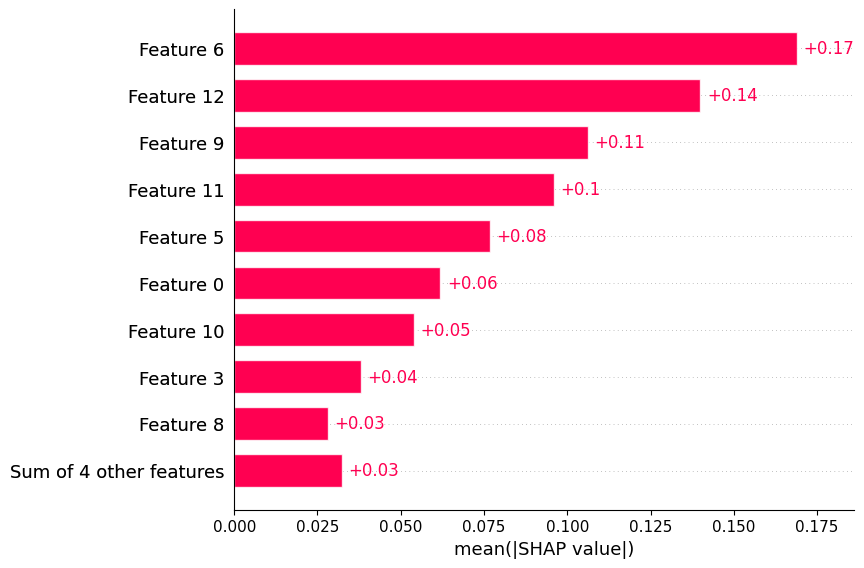

In [ ]:
import sklearn
import shap

explainer = shap.Explainer(rf.predict, X_test)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)

Model coefficients:

MedInc = 0.42563
HouseAge = 0.01033
AveRooms = -0.1161
AveBedrms = 0.66385
Population = 3e-05
AveOccup = -0.26096
Latitude = -0.46734
Longitude = -0.46272


ExactExplainer explainer: 1001it [00:14, 29.71it/s]                          


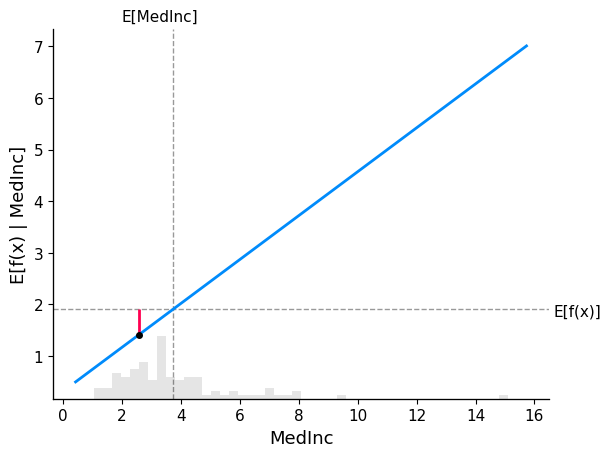

In [ ]:
import sklearn
import shap

# a classic housing price dataset
X, y = shap.datasets.california(n_points=1000)

X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(5))

# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)